In [31]:
import pandas as pd
import numpy as np
import glob
import os
import re
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.linalg import block_diag

import os
import json

In [32]:
filepath_hm3d = "vqa_results/bbq/hm3d/evaluated/"
filepath_replica_cad = "vqa_results/bbq/replica_cad/evaluated/"

In [33]:
# hm3d_labels = ['camera_lights_1', 'no_lights_1', 'velocity_1', 'camera_lights_2', 'no_lights_2', 'velocity_2']
# hm3d_scenes = ['00800-TEEsavR23oF', '00802-wcojb4TFT35', '00803-k1cupFYWXJ6', '00808-y9hTuugGdiq']

hm3d_labels = ['camera_lights', 'no_lights', 'velocity']
hm3d_scenes = [
    '00800-TEEsavR23oF', 
    '00802-wcojb4TFT35', 
    '00803-k1cupFYWXJ6', 
    '00808-y9hTuugGdiq', 
    '00810-CrMo8WxCyVb', 
    '00813-svBbv1Pavdk', 
    '00814-p53SfW6mjZe',
    '00815-h1zeeAwLh9Z'
]

replica_cad_labels = ['baseline',  'no_lights', 'camera_lights', 'dynamic_lights', 'velocity'] #, 'no_lights'
replica_cad_scenes = [
    'apt_0',
    'apt_3',
    'v3_sc0_staging_00',
    'v3_sc0_staging_12',
    'v3_sc0_staging_16',
    'v3_sc0_staging_19',
    'v3_sc0_staging_20',
    'v3_sc1_staging_00',
    'v3_sc1_staging_06',
    'v3_sc1_staging_12',
    'v3_sc1_staging_19',
    'v3_sc1_staging_20',
    'v3_sc2_staging_00',
    'v3_sc2_staging_11',
    'v3_sc2_staging_13',
    'v3_sc2_staging_19',
    'v3_sc2_staging_20',
    'v3_sc3_staging_03',
    'v3_sc3_staging_04',
    'v3_sc3_staging_08',
    'v3_sc3_staging_15',
    'v3_sc3_staging_20',
]

In [34]:
def get_filepathes(scenes, labels, filepath, dataset_name):   
    table = []
    for scene in scenes:
        for label in labels:
            if dataset_name == 'hm3d':
                json_path = os.path.join(filepath, f'{scene}_{label}_evaluated.json')
            elif dataset_name == 'replica_cad':
                json_path = os.path.join(filepath, f"{scene}_{label}_evaluated.json")
            else:
                raise ValueError("Invalid dataset name")
        

            table.append({
                'scene': scene, 
                'label': label, 
                'json_path': json_path,
            })

    return pd.DataFrame(table)

In [35]:
hm3d_file_df = get_filepathes(hm3d_scenes, hm3d_labels, filepath_hm3d, dataset_name='hm3d')
hm3d_file_df.head()

,scene,label,json_path
0,00800-TEEsavR23oF,camera_lights,vqa_results/bbq/hm3d/evaluated/00800-TEEsavR23...
1,00800-TEEsavR23oF,no_lights,vqa_results/bbq/hm3d/evaluated/00800-TEEsavR23...
2,00800-TEEsavR23oF,velocity,vqa_results/bbq/hm3d/evaluated/00800-TEEsavR23...
3,00802-wcojb4TFT35,camera_lights,vqa_results/bbq/hm3d/evaluated/00802-wcojb4TFT...
4,00802-wcojb4TFT35,no_lights,vqa_results/bbq/hm3d/evaluated/00802-wcojb4TFT...


In [36]:
replica_cad_file_df = get_filepathes(replica_cad_scenes, replica_cad_labels, filepath_replica_cad, dataset_name='replica_cad')
replica_cad_file_df.head()

,scene,label,json_path
0,apt_0,baseline,vqa_results/bbq/replica_cad/evaluated/apt_0_ba...
1,apt_0,no_lights,vqa_results/bbq/replica_cad/evaluated/apt_0_no...
2,apt_0,camera_lights,vqa_results/bbq/replica_cad/evaluated/apt_0_ca...
3,apt_0,dynamic_lights,vqa_results/bbq/replica_cad/evaluated/apt_0_dy...
4,apt_0,velocity,vqa_results/bbq/replica_cad/evaluated/apt_0_ve...


In [37]:
import json
import os
import pandas as pd
from collections import defaultdict


filepaths = replica_cad_file_df['json_path'].to_list() + hm3d_file_df['json_path'].to_list()

metrics = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0, "TN": 0})

# Process each JSON file
for filepath in filepaths:
    with open(filepath, "r") as f:
        data = json.load(f)  # Load JSON data
    
    for item in data:
        category = item["category"]
        
        # Only consider binary questions
        if "Binary" in category:
            ground_truth = item["answer"].strip().lower()
            predicted = item["scene_graph_answer"].strip().lower()
            
            # Update TP, FP, FN, TN counts
            if ground_truth == "yes" and predicted == "yes":
                metrics[category]["TP"] += 1
            elif ground_truth == "no" and predicted == "yes":
                metrics[category]["FP"] += 1
            elif ground_truth == "yes" and predicted == "no":
                metrics[category]["FN"] += 1
            elif ground_truth == "no" and predicted == "no":
                metrics[category]["TN"] += 1

# Convert to DataFrame for better visualization
df_metrics = pd.DataFrame.from_dict(metrics, orient="index")
df_metrics['precision'] = df_metrics['TP'] / (df_metrics['TP'] + df_metrics['FP'])
df_metrics['recall'] = df_metrics['TP'] / (df_metrics['TP'] + df_metrics['FN'])
df_metrics['pos_percentile'] = (df_metrics['TP'] + df_metrics['FN'])  / (df_metrics['TP'] + df_metrics['FP'] + df_metrics['TN'] + df_metrics['FN'])
df_metrics['neg_percentile'] = (df_metrics['FP'] + df_metrics['TN'])  / (df_metrics['TP'] + df_metrics['FP'] + df_metrics['TN'] + df_metrics['FN'])
df_metrics

,TP,FP,FN,TN,precision,recall,pos_percentile,neg_percentile
Binary General,835,210,1412,1633,0.799043,0.371607,0.549389,0.450611
Binary Existence-Based,2,362,31,3264,0.005495,0.060606,0.009019,0.990981
Binary Logical,2088,105,1396,467,0.952120,0.599311,0.858974,0.141026


In [38]:
def get_file_statistics(filepath):
    statistics = {}
    
    with open(filepath, 'r') as file:
        data = json.load(file)
        print(filepath)

        for entry in data:
            category = entry.get('category')
            correctness = entry.get('similar')

            if category not in statistics:
                statistics[category] = {'total': 0, 'correct': 0, 'wrong': 0}

            statistics[category]['total'] += 1

            if correctness.lower() == 'yes':
                statistics[category]['correct'] += 1
            elif correctness.lower() == 'no':
                statistics[category]['wrong'] += 1
    
    stats_list = [{'category': category, **stats} for category, stats in statistics.items()]            
                
    return pd.DataFrame(stats_list)

In [39]:
def get_statistics_df(file_df, dataset_name):
    stats_list = []

    for _, (scene, label, filepath) in file_df.iterrows():
        statistics = get_file_statistics(filepath)
        
        statistics['scene'] = scene
        statistics['label'] = label
        
        stats_list.append(pd.DataFrame(statistics))
        
    return pd.concat(stats_list, ignore_index=True)

In [40]:
hm3d_stats_df = get_statistics_df(hm3d_file_df, dataset_name='hm3d')
hm3d_stats_df

vqa_results/bbq/hm3d/evaluated/00800-TEEsavR23oF_camera_lights_evaluated.json
vqa_results/bbq/hm3d/evaluated/00800-TEEsavR23oF_no_lights_evaluated.json
vqa_results/bbq/hm3d/evaluated/00800-TEEsavR23oF_velocity_evaluated.json
vqa_results/bbq/hm3d/evaluated/00802-wcojb4TFT35_camera_lights_evaluated.json
vqa_results/bbq/hm3d/evaluated/00802-wcojb4TFT35_no_lights_evaluated.json
vqa_results/bbq/hm3d/evaluated/00802-wcojb4TFT35_velocity_evaluated.json
vqa_results/bbq/hm3d/evaluated/00803-k1cupFYWXJ6_camera_lights_evaluated.json
vqa_results/bbq/hm3d/evaluated/00803-k1cupFYWXJ6_no_lights_evaluated.json
vqa_results/bbq/hm3d/evaluated/00803-k1cupFYWXJ6_velocity_evaluated.json
vqa_results/bbq/hm3d/evaluated/00808-y9hTuugGdiq_camera_lights_evaluated.json
vqa_results/bbq/hm3d/evaluated/00808-y9hTuugGdiq_no_lights_evaluated.json
vqa_results/bbq/hm3d/evaluated/00808-y9hTuugGdiq_velocity_evaluated.json
vqa_results/bbq/hm3d/evaluated/00810-CrMo8WxCyVb_camera_lights_evaluated.json
vqa_results/bbq/hm3d/e

,category,total,correct,wrong,scene,label
0,Binary General,17,12,5,00800-TEEsavR23oF,camera_lights
1,Binary Logical,11,7,4,00800-TEEsavR23oF,camera_lights
2,Measurement,3,0,3,00800-TEEsavR23oF,camera_lights
3,Binary Existence-Based,9,7,2,00800-TEEsavR23oF,camera_lights
4,Object Attributes,14,3,11,00800-TEEsavR23oF,camera_lights
...,...,...,...,...,...,...
181,Measurement,7,2,5,00815-h1zeeAwLh9Z,velocity
182,Object Attributes,6,3,3,00815-h1zeeAwLh9Z,velocity
183,Object Relations - Spatial,5,2,3,00815-h1zeeAwLh9Z,velocity
184,Object Relations - Functional,2,0,2,00815-h1zeeAwLh9Z,velocity


# Overall

In [41]:
hm3d_file_df

,scene,label,json_path
0,00800-TEEsavR23oF,camera_lights,vqa_results/bbq/hm3d/evaluated/00800-TEEsavR23...
1,00800-TEEsavR23oF,no_lights,vqa_results/bbq/hm3d/evaluated/00800-TEEsavR23...
2,00800-TEEsavR23oF,velocity,vqa_results/bbq/hm3d/evaluated/00800-TEEsavR23...
3,00802-wcojb4TFT35,camera_lights,vqa_results/bbq/hm3d/evaluated/00802-wcojb4TFT...
4,00802-wcojb4TFT35,no_lights,vqa_results/bbq/hm3d/evaluated/00802-wcojb4TFT...
5,00802-wcojb4TFT35,velocity,vqa_results/bbq/hm3d/evaluated/00802-wcojb4TFT...
6,00803-k1cupFYWXJ6,camera_lights,vqa_results/bbq/hm3d/evaluated/00803-k1cupFYWX...
7,00803-k1cupFYWXJ6,no_lights,vqa_results/bbq/hm3d/evaluated/00803-k1cupFYWX...
8,00803-k1cupFYWXJ6,velocity,vqa_results/bbq/hm3d/evaluated/00803-k1cupFYWX...
9,00808-y9hTuugGdiq,camera_lights,vqa_results/bbq/hm3d/evaluated/00808-y9hTuugGd...


In [42]:

approaches = ['conceptgraphs', 'bbq']

approaches_list = []

for approach in approaches:
    filepath_hm3d = f"vqa_results/{approach}/hm3d/evaluated/"
    filepath_replica_cad = f"vqa_results/{approach}/replica_cad/evaluated/"

    hm3d_file_df = get_filepathes(hm3d_scenes, hm3d_labels, filepath_hm3d, dataset_name='hm3d')
    replica_cad_file_df = get_filepathes(replica_cad_scenes, replica_cad_labels, filepath_replica_cad, dataset_name='replica_cad')

    hm3d_stats_df = get_statistics_df(hm3d_file_df, dataset_name='hm3d')
    replica_cad_stats_df = get_statistics_df(replica_cad_file_df, dataset_name='replica_cad')
    
    hm3d_stats_df['dataset'] = 'hm3d'
    replica_cad_stats_df['dataset'] = 'replica_cad'
    
    approach_df = pd.concat([hm3d_stats_df, replica_cad_stats_df], ignore_index=True)
    approach_df['approach'] = approach
    
    approaches_list.append(approach_df)
    
overall_df = pd.concat(approaches_list, ignore_index=True)

vqa_results/conceptgraphs/hm3d/evaluated/00800-TEEsavR23oF_camera_lights_evaluated.json
vqa_results/conceptgraphs/hm3d/evaluated/00800-TEEsavR23oF_no_lights_evaluated.json
vqa_results/conceptgraphs/hm3d/evaluated/00800-TEEsavR23oF_velocity_evaluated.json
vqa_results/conceptgraphs/hm3d/evaluated/00802-wcojb4TFT35_camera_lights_evaluated.json
vqa_results/conceptgraphs/hm3d/evaluated/00802-wcojb4TFT35_no_lights_evaluated.json
vqa_results/conceptgraphs/hm3d/evaluated/00802-wcojb4TFT35_velocity_evaluated.json
vqa_results/conceptgraphs/hm3d/evaluated/00803-k1cupFYWXJ6_camera_lights_evaluated.json
vqa_results/conceptgraphs/hm3d/evaluated/00803-k1cupFYWXJ6_no_lights_evaluated.json
vqa_results/conceptgraphs/hm3d/evaluated/00803-k1cupFYWXJ6_velocity_evaluated.json
vqa_results/conceptgraphs/hm3d/evaluated/00808-y9hTuugGdiq_camera_lights_evaluated.json
vqa_results/conceptgraphs/hm3d/evaluated/00808-y9hTuugGdiq_no_lights_evaluated.json
vqa_results/conceptgraphs/hm3d/evaluated/00808-y9hTuugGdiq_velo

In [43]:
overall_df

,category,total,correct,wrong,scene,label,dataset,approach
0,Binary General,17,10,7,00800-TEEsavR23oF,camera_lights,hm3d,conceptgraphs
1,Binary Logical,11,8,3,00800-TEEsavR23oF,camera_lights,hm3d,conceptgraphs
2,Measurement,3,2,1,00800-TEEsavR23oF,camera_lights,hm3d,conceptgraphs
3,Binary Existence-Based,9,6,3,00800-TEEsavR23oF,camera_lights,hm3d,conceptgraphs
4,Object Attributes,14,1,13,00800-TEEsavR23oF,camera_lights,hm3d,conceptgraphs
...,...,...,...,...,...,...,...,...
2077,Measurement,7,3,4,v3_sc3_staging_20,velocity,replica_cad,bbq
2078,Object Attributes,25,10,15,v3_sc3_staging_20,velocity,replica_cad,bbq
2079,Object Relations - Spatial,30,7,23,v3_sc3_staging_20,velocity,replica_cad,bbq
2080,Object Relations - Functional,1,0,1,v3_sc3_staging_20,velocity,replica_cad,bbq


In [44]:
overall_df[overall_df['total'] != (overall_df['correct'] + overall_df['wrong'])]

,category,total,correct,wrong,scene,label,dataset,approach
1286,Binary Existence-Based,35,30,3,apt_3,camera_lights,replica_cad,bbq


In [45]:
grouped_overall_df = overall_df.groupby(['approach', 'dataset', 'label', 'category']).agg({
    'total': 'sum',
    'correct': 'sum',
    'wrong': 'sum',
}).reset_index()
grouped_overall_df

,approach,dataset,label,category,total,correct,wrong
0,bbq,hm3d,camera_lights,Binary Existence-Based,98,83,15
1,bbq,hm3d,camera_lights,Binary General,137,71,66
2,bbq,hm3d,camera_lights,Binary Logical,106,52,54
3,bbq,hm3d,camera_lights,Comparison,46,15,31
4,bbq,hm3d,camera_lights,Measurement,65,14,51
...,...,...,...,...,...,...,...
123,conceptgraphs,replica_cad,velocity,Comparison,179,92,87
124,conceptgraphs,replica_cad,velocity,Measurement,206,39,167
125,conceptgraphs,replica_cad,velocity,Object Attributes,691,124,567
126,conceptgraphs,replica_cad,velocity,Object Relations - Functional,35,7,28


In [46]:
grouped_overall_df[grouped_overall_df['category'] == 'Object Relations - Functional']

,approach,dataset,label,category,total,correct,wrong
6,bbq,hm3d,camera_lights,Object Relations - Functional,16,2,14
14,bbq,hm3d,no_lights,Object Relations - Functional,16,1,15
22,bbq,hm3d,velocity,Object Relations - Functional,16,2,14
30,bbq,replica_cad,baseline,Object Relations - Functional,35,12,23
38,bbq,replica_cad,camera_lights,Object Relations - Functional,35,12,23
46,bbq,replica_cad,dynamic_lights,Object Relations - Functional,35,8,27
54,bbq,replica_cad,no_lights,Object Relations - Functional,35,11,24
62,bbq,replica_cad,velocity,Object Relations - Functional,35,11,24
70,conceptgraphs,hm3d,camera_lights,Object Relations - Functional,16,1,15
78,conceptgraphs,hm3d,no_lights,Object Relations - Functional,16,2,14


In [47]:
grouped_overall_df[grouped_overall_df['dataset'] == 'hm3d']

,approach,dataset,label,category,total,correct,wrong
0,bbq,hm3d,camera_lights,Binary Existence-Based,98,83,15
1,bbq,hm3d,camera_lights,Binary General,137,71,66
2,bbq,hm3d,camera_lights,Binary Logical,106,52,54
3,bbq,hm3d,camera_lights,Comparison,46,15,31
4,bbq,hm3d,camera_lights,Measurement,65,14,51
5,bbq,hm3d,camera_lights,Object Attributes,110,15,95
6,bbq,hm3d,camera_lights,Object Relations - Functional,16,2,14
7,bbq,hm3d,camera_lights,Object Relations - Spatial,103,14,89
8,bbq,hm3d,no_lights,Binary Existence-Based,98,81,17
9,bbq,hm3d,no_lights,Binary General,137,84,53


In [48]:
grouped_overall_df['accuracy'] = grouped_overall_df['correct'] / grouped_overall_df['total']
grouped_overall_df

,approach,dataset,label,category,total,correct,wrong,accuracy
0,bbq,hm3d,camera_lights,Binary Existence-Based,98,83,15,0.846939
1,bbq,hm3d,camera_lights,Binary General,137,71,66,0.518248
2,bbq,hm3d,camera_lights,Binary Logical,106,52,54,0.490566
3,bbq,hm3d,camera_lights,Comparison,46,15,31,0.326087
4,bbq,hm3d,camera_lights,Measurement,65,14,51,0.215385
...,...,...,...,...,...,...,...,...
123,conceptgraphs,replica_cad,velocity,Comparison,179,92,87,0.513966
124,conceptgraphs,replica_cad,velocity,Measurement,206,39,167,0.189320
125,conceptgraphs,replica_cad,velocity,Object Attributes,691,124,567,0.179450
126,conceptgraphs,replica_cad,velocity,Object Relations - Functional,35,7,28,0.200000


In [49]:
grouped_overall_df[['label', 'category', 'accuracy']]

,label,category,accuracy
0,camera_lights,Binary Existence-Based,0.846939
1,camera_lights,Binary General,0.518248
2,camera_lights,Binary Logical,0.490566
3,camera_lights,Comparison,0.326087
4,camera_lights,Measurement,0.215385
...,...,...,...
123,velocity,Comparison,0.513966
124,velocity,Measurement,0.189320
125,velocity,Object Attributes,0.179450
126,velocity,Object Relations - Functional,0.200000


## Visualization

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Circle

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'DejaVu Sans'

In [51]:
def draw_polar_plot(df, ax, colors_dict):
    # df.loc[:, 'category'] = df['category'].replace(' ', '\n')
    # df['category'] = df['category'].replace(' - ', '\n')
    # df['category'] = df['category'].replace('-', '\n')
    
    categories = df['category'].unique()
   
    categories = [category.replace(' - ', '\n').replace(' ', '\n').replace('-', '\n') for category in categories]

    num_categories = len(df['category'].unique())
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    angles = angles + angles[:1]
    
    for i in [0.2, 0.4, 0.6, 0.8]:
        circle = Circle((0, 0), i, transform=ax.transData._b, 
                        fill=True, alpha=0.15, color='gray', zorder=5)  # Increased alpha for visibility
        ax.add_artist(circle)
        
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    lines = None

    for i, label in enumerate(df['label'].unique().tolist()[::-1]):
        accuracies = df[df['label'] == label]['accuracy'].tolist()
        accuracies += accuracies[:1]
        line = ax.plot(angles, accuracies, linewidth=8, linestyle='solid', 
                color=colors_dict[label], marker='o', 
                markersize=10, markerfacecolor=colors_dict[label], markeredgewidth=2, 
                markeredgecolor='white', label=label, zorder=2)
        
        if lines is None:
            lines = line
        else:
            lines += line
            
        ax.fill(angles, accuracies, alpha=0.15, color=colors_dict[label], zorder=2)

    ax.set_xticks(angles[:-1], categories, size=30, fontweight='bold', zorder=10000)
    for label in ax.get_xticklabels():
        label.set_zorder(10)  # Higher zorder makes them appear above other elements

    
    # ax.legend(loc='upper right', bbox_to_anchor=(0.2, 0.05), fontsize=22, framealpha=0.7, edgecolor='black')

    ax.set_ylim(0, 1)
    # ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Less cluttered gridlines
    # ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=30, zorder=0)
    
    ax.set_rgrids(
        [0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=["20%", "40%", "60%", "80%", "100%"],
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=30,
        zorder=0
    )
    
    for label in ax.get_yticklabels():
        label.set_zorder(0)

    ax.spines['polar'].set_visible(True)
    ax.spines['polar'].set_linewidth(1.5)
    
    # # Set x-tick labels to front
    for label in ax.get_yticklabels():
        label.set_zorder(0)
        
    ax.xaxis.set_zorder(1)  # For angular (theta) gridlines
    ax.yaxis.set_zorder(1)  # For radial (r) gridlines
    
    # ax.grid(False)
    # ax.spines['polar'].set_visible(False)
    ax.spines['polar'].set_zorder(0)
    
    
    ax.set_rlabel_position(-25)  # Puts labels near the top-left
    
    return lines
    


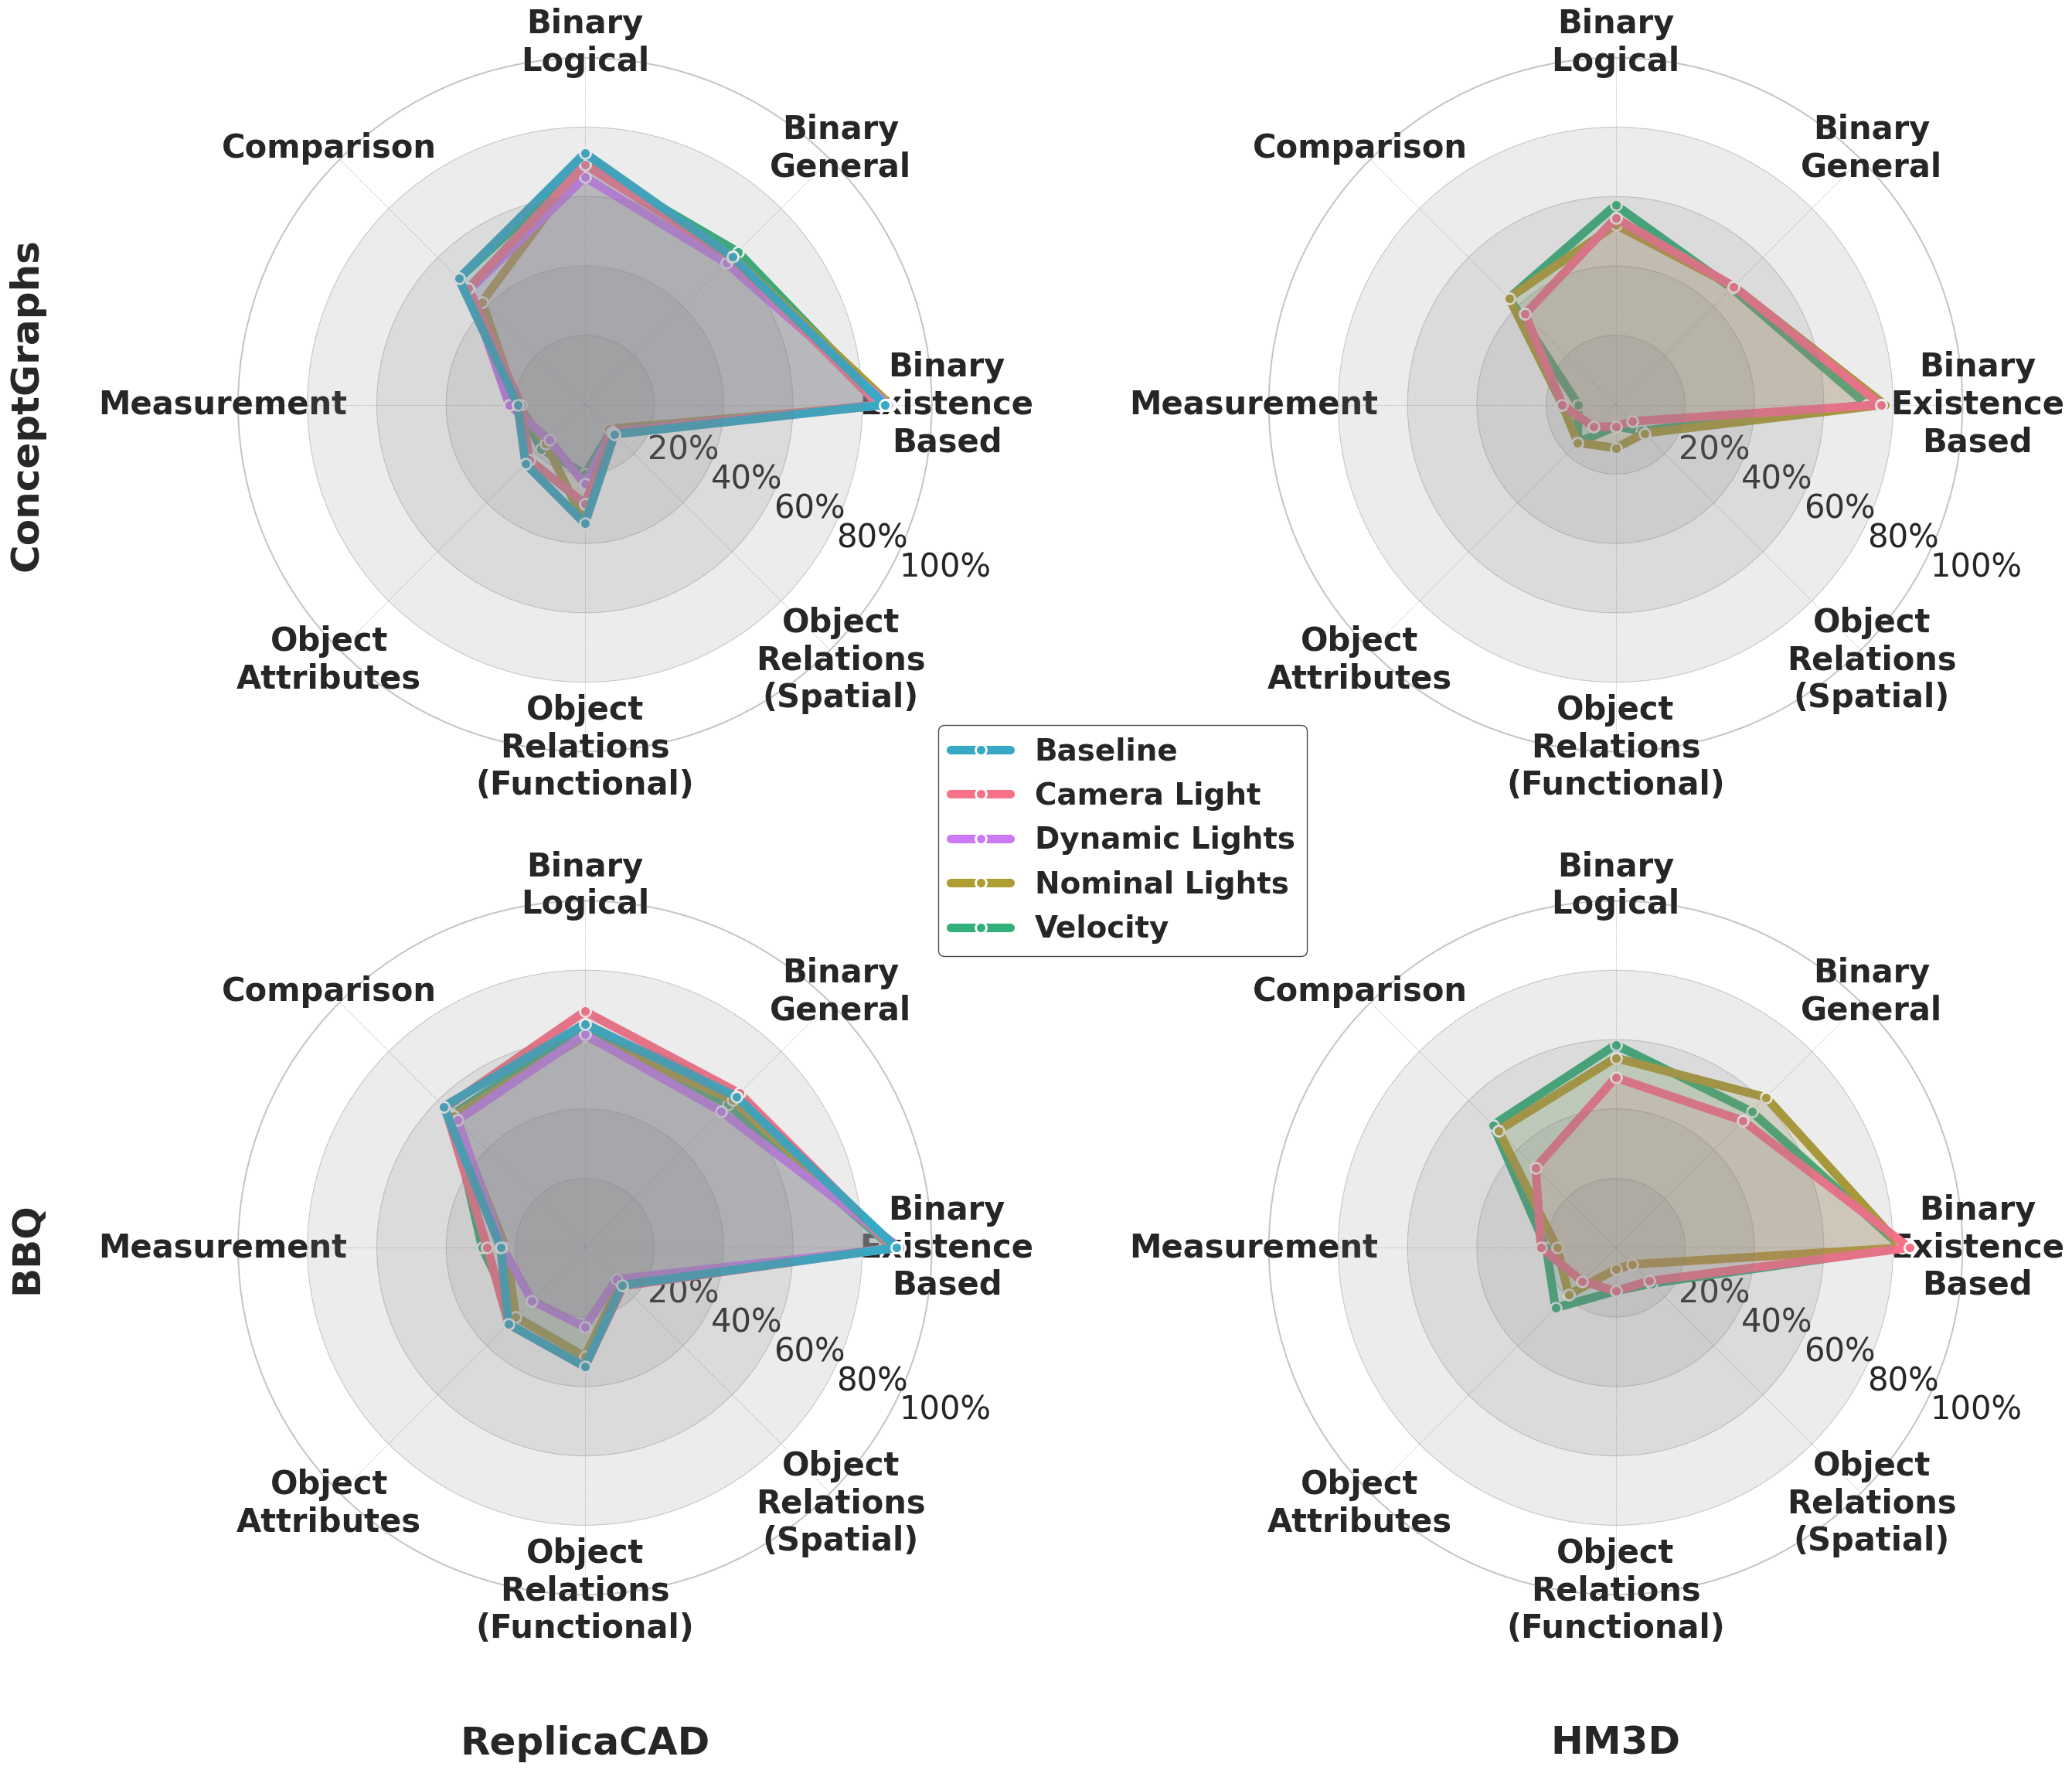

In [52]:
visual_df = grouped_overall_df.copy()
visual_df.sort_values(by=['category', 'label'], ascending=[True, True])
visual_df['category'] = visual_df['category'].replace({
    'Object Relations - Functional' : 'Object Relations (Functional)\n',
    'Object Relations - Spatial': 'Object Relations (Spatial)'
})

visual_df['label'] = visual_df['label'].replace({
    'baseline': 'Baseline', 
    'camera_lights': 'Camera Light',
    'dynamic_lights': 'Dynamic Lights',
    'no_lights': 'Nominal Lights',
    'velocity': 'Velocity'
})

visual_df['approach'] = visual_df['approach'].replace({'conceptgraphs': 'ConceptGraphs', 'bbq': 'BBQ'})
visual_df['dataset'] = visual_df['dataset'].replace({'replica_cad': 'ReplicaCAD', 'hm3d': 'HM3D'})

labels = visual_df['label'].unique()
colors = sns.color_palette("husl", len(labels))
colors_dict = {label: color for label, color in zip(labels, colors)}

drop_condition = visual_df[(visual_df['dataset'] == 'HM3D') & (visual_df['category'] == 'Object Relations (Functional)')].index
visual_df = visual_df.drop(drop_condition)

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(28, 23), subplot_kw={'projection': 'polar'})
# plt.subplots_adjust(wspace=1.0, hspace=0.0)  
axes = axes.flatten()

i = 0
datasets = ['ReplicaCAD', 'HM3D']
approaches = ['ConceptGraphs', 'BBQ']

for approach in approaches:
    for dataset in datasets:
        df = visual_df[(visual_df['dataset'] == dataset) & (visual_df['approach'] == approach)]
        
        if i == 0:
            lines = draw_polar_plot(df, axes[i], colors_dict)
        else:
            draw_polar_plot(df, axes[i], colors_dict)
        
        if i > 1:
            axes[i].set_xlabel(dataset, fontsize=36, labelpad=40, fontweight='bold')
        
        if i % 2 == 0:
            axes[i].set_ylabel(approach, fontsize=36, labelpad=180, fontweight='bold')
        
        i += 1

from matplotlib.font_manager import FontProperties
bold_font = FontProperties(weight='bold', size=28)        
fig.legend(handles=lines[::-1], loc='center', bbox_to_anchor=(0.54, 0.525), prop=bold_font, framealpha=0.7, edgecolor='black')  
    
plt.tight_layout()
plt.savefig("vqa_polar_plots.pdf")
plt.savefig("vqa_polar_plots.png")
plt.show()

In [53]:
grouped_overall_df[(grouped_overall_df['approach'] == 'conceptgraphs') & (grouped_overall_df['dataset'] == 'replica_cad')]

,approach,dataset,label,category,total,correct,wrong,accuracy
88,conceptgraphs,replica_cad,baseline,Binary Existence-Based,678,586,92,0.864307
89,conceptgraphs,replica_cad,baseline,Binary General,754,454,300,0.602122
90,conceptgraphs,replica_cad,baseline,Binary Logical,750,544,206,0.725333
91,conceptgraphs,replica_cad,baseline,Comparison,179,92,87,0.513966
92,conceptgraphs,replica_cad,baseline,Measurement,206,40,166,0.194175
93,conceptgraphs,replica_cad,baseline,Object Attributes,691,167,524,0.241679
94,conceptgraphs,replica_cad,baseline,Object Relations - Functional,35,12,23,0.342857
95,conceptgraphs,replica_cad,baseline,Object Relations - Spatial,762,92,670,0.120735
96,conceptgraphs,replica_cad,camera_lights,Binary Existence-Based,678,574,104,0.846608
97,conceptgraphs,replica_cad,camera_lights,Binary General,754,452,302,0.599469


In [58]:
grouped = grouped_overall_df.groupby(['category']).agg({
    'total': 'sum',
    'correct': 'sum',
    'wrong': 'sum',
}).reset_index()

grouped['percentile'] = (grouped['total'] / grouped['total'].sum() * 100).round(1)
grouped

,category,total,correct,wrong,percentile
0,Binary Existence-Based,7368,6435,931,16.5
1,Binary General,8362,4947,3415,18.7
2,Binary Logical,8136,5336,2800,18.2
3,Comparison,2066,1036,1030,4.6
4,Measurement,2450,532,1918,5.5
5,Object Attributes,7570,1733,5837,17.0
6,Object Relations - Functional,446,112,334,1.0
7,Object Relations - Spatial,8238,1045,7193,18.5
